In [1]:
import pandas as pd
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=2)
sns.set_palette("Dark2")

In [2]:
import numpy as np

results = pd.read_parquet("./timing_models_scaling_ttf.gzip")
results = results[np.isin(results["model"], ("fitted-rolling-ttf", "rolling-ttf", "fitted-naive"))].copy()

def _config(s: pd.Series):
    if s["model"] == "rolling-ttf":
        return s["neuroticism"][0].upper() + s["neuroticism"][1:] + " neuroticism"
    elif s["model"] == "fitted-rolling-ttf":
        return "ExGaussian fit,\n" + s["neuroticism"] + " neuroticism"
    else:
        return "Reference"

results["Configuration"] = (
    results[["model", "neuroticism"]]
    .apply(_config, axis=1)
    .astype(pd.CategoricalDtype(["Low neuroticism", "High neuroticism", "ExGaussian fit,\nlow neuroticism", "ExGaussian fit,\nhigh neuroticism", "Reference"]))
)

results["cumulative_duration_min"] = results["cumulative_duration"] / 60.0


results

,neuroticism,repetition,step,exec_time,ttf,duration,cumulative_duration,model,Configuration,cumulative_duration_min
0,n/a,1,1,10.353867,0.0,10.353867,10.353867,fitted-naive,Reference,0.172564
1,n/a,1,2,5.431794,0.0,5.431794,15.785661,fitted-naive,Reference,0.263094
2,n/a,1,3,4.712621,0.0,4.712621,20.498282,fitted-naive,Reference,0.341638
3,n/a,1,4,3.096165,0.0,3.096165,23.594448,fitted-naive,Reference,0.393241
4,n/a,1,5,9.940510,0.0,9.940510,33.534957,fitted-naive,Reference,0.558916
...,...,...,...,...,...,...,...,...,...,...
1124995,high,90,96,4.073724,5.0,9.073724,1089.978151,rolling-ttf,High neuroticism,18.166303
1124996,high,90,97,5.976498,5.0,10.976498,1100.954650,rolling-ttf,High neuroticism,18.349244
1124997,high,90,98,4.174604,5.0,9.174604,1110.129254,rolling-ttf,High neuroticism,18.502154
1124998,high,90,99,16.639348,5.0,21.639348,1131.768602,rolling-ttf,High neuroticism,18.862810


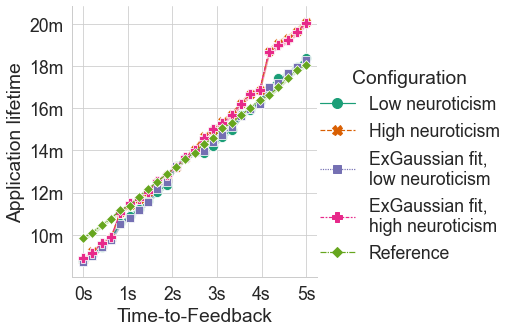

In [3]:
import  matplotlib.ticker as tkr

fg = sns.relplot(
    kind="line",
    # err_style="ba",
    data=results[results["step"] == results["step"].max()],
    x="ttf",
    y="cumulative_duration_min",
    hue="Configuration",
    # aspect=1.5,
    style="Configuration",
    markers=True,
    markersize=10,
)
for ax in fg.axes.flat:
    ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}m"))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0f}s"))
for legend_handle in fg.legend.legendHandles:
    legend_handle.set_markersize(10)
fg.set_axis_labels("Time-to-Feedback", "Application lifetime")
plt.show()

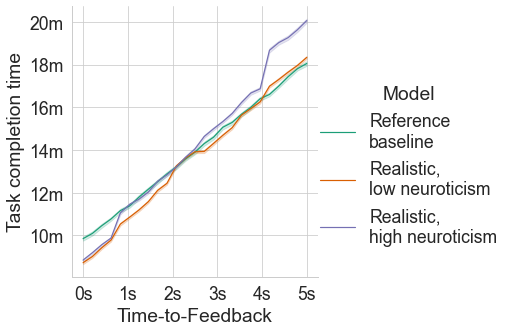

In [17]:
results2 = results.copy()
results2["Model"] = results2["neuroticism"].apply(lambda x: {"n/a": "Reference\nbaseline", "low": "Realistic,\nlow neuroticism", "high": "Realistic,\nhigh neuroticism"}[x])

fg = sns.relplot(
    kind="line",
    err_style="band",
    data=results2[results2["step"] == results2["step"].max()],
    x="ttf",
    y="cumulative_duration_min",
    hue="Model",
    # aspect=1.5,
    # style="Model",
    # markers=True,
    # markersize=10,
)
for ax in fg.axes.flat:
    ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}m"))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:0.0f}s"))
for legend_handle in fg.legend.legendHandles:
    legend_handle.set_markersize(10)
fg.set_axis_labels("Time-to-Feedback", "Task completion time")
plt.show()

In [4]:
durations = results[results["step"] == results["step"].max()]
durations = durations[np.isin(durations["ttf"], (0.0, 5.0))]
durations = durations[np.isin(durations["Configuration"], ("Reference", "ExGaussian fit,\nhigh neuroticism"))]
durdiff = durations.groupby(["Configuration", "ttf"], observed=True)["cumulative_duration"].mean().unstack(level=-1)
durdiff["diff"] = durdiff[5.0] - durdiff[0.0]
(durdiff["diff"].iloc[1] - durdiff["diff"].iloc[0]) / durdiff["diff"].iloc[0]

0.35819617166986667

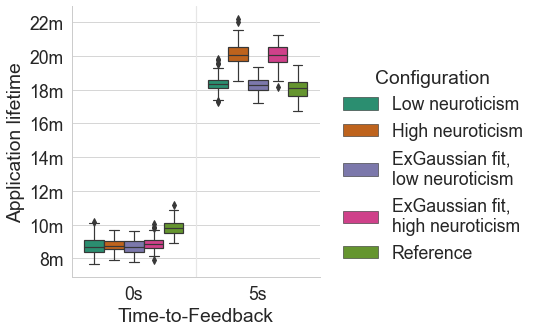

In [5]:
fg = sns.catplot(
    kind="box",
    data=results[(results["step"] == results["step"].max()) & np.isin(results["ttf"], (0.0, 5.0))],
    x="ttf",
    y="cumulative_duration_min",
    hue="Configuration",
    # aspect=1.5,
    # style="Configuration",
    # markers=True,
)
for ax in fg.axes.flat:
    # ax.xaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}m"))
    ax.set_xticklabels(["0s", "5s"])
    # ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{p:0.0f}s"))

fg.refline(x=0.5, linestyle="-", color=".9")
fg.set_axis_labels("Time-to-Feedback", "Application lifetime")
plt.show()

In [6]:
durations = (
    results[(results["step"] == results["step"].max()) & np.isin(results["ttf"], (0.0, 1.25, 2.5, 3.75, 5.0))]
    [["Configuration", "cumulative_duration", "repetition", "ttf"]]
    .set_index(["Configuration", "ttf", "repetition"], verify_integrity=True)
)
durations

cumulative_duration
Configuration    ttf repetition                     
Reference        0.0 1                    573.714344
                     2                    545.987371
                     3                    595.494591
                     4                    554.284038
                     5                    622.702275
...                                              ...
High neuroticism 5.0 86                  1231.337407
                     87                  1332.326082
                     88                  1180.066742
                     89                  1210.857204
                     90                  1140.338726

[2250 rows x 1 columns]

In [7]:
ix = pd.IndexSlice
ref_durations = durations.loc[ix["Reference"], "cumulative_duration"]
ref_durations

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/2151793829.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_durations = durations.loc[ix["Reference"], "cumulative_duration"]


ttf  repetition
0.0  1              573.714344
     2              545.987371
     3              595.494591
     4              554.284038
     5              622.702275
                      ...     
5.0  86            1084.410484
     87            1080.747008
     88            1050.043164
     89            1046.777528
     90            1054.297533
Name: cumulative_duration, Length: 450, dtype: float64

In [8]:
non_ref_durations = durations[durations.index.map(lambda i: i[0] != "Reference")].copy()
non_ref_durations

cumulative_duration
Configuration                    ttf repetition                     
ExGaussian fit,\nlow neuroticism 0.0 1                    508.245541
                                     2                    487.976260
                                     3                    538.828567
                                     4                    541.267870
                                     5                    550.047717
...                                                              ...
High neuroticism                 5.0 86                  1231.337407
                                     87                  1332.326082
                                     88                  1180.066742
                                     89                  1210.857204
                                     90                  1140.338726

[1800 rows x 1 columns]

In [9]:
import pingouin as pg

ix = pd.IndexSlice

def diff_wrt_reference(ttf_df: pd.DataFrame) -> pd.DataFrame:
    ref_durations = ttf_df.loc[ix["Reference"], "cumulative_duration"].to_numpy()

    def _diff_wrt_ref(durations: pd.Series) -> pd.Series:
        ref_mean = ref_durations.mean()
        ttest = pg.ttest(durations.to_numpy(), ref_durations, alternative="two-sided")
        diff_raw = durations.mean() - ref_mean
        diff = diff_raw / ref_mean
        ci = ttest.at["T-test", "CI95%"]

        pval = ttest.at["T-test", "p-val"]
        sig_pval = pval < 0.05

        return pd.Series({"diff": diff, "diff_raw": diff_raw, "p-val": pval, "p < 0.05": sig_pval, "CI95_Low": ci[0] / ref_mean, "CI95_High": ci[1] /ref_mean}, name="Result")

    return ttf_df.groupby("Configuration", observed=True)["cumulative_duration"].apply(_diff_wrt_ref)

duration_diff = durations.groupby(["ttf"], observed=True).apply(diff_wrt_reference).stack(level=0).reset_index()
duration_diff = duration_diff[duration_diff["Configuration"] != "Reference"].copy()
duration_diff["Configuration"] = duration_diff["Configuration"].cat.remove_unused_categories()
duration_diff

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/930268212.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_durations = ttf_df.loc[ix["Reference"], "cumulative_duration"].to_numpy()
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/930268212.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_durations = ttf_df.loc[ix["Reference"], "cumulative_duration"].to_numpy()
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/930268212.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_durations = ttf_df.loc[ix["Reference"], "cumulative_duration"].to_numpy()
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/930268212.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_durations = ttf_df.loc[ix["Reference"], "cumulative_duration"].to_numpy()
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/930

,ttf,Configuration,CI95_High,CI95_Low,diff,diff_raw,p < 0.05,p-val
0,0.00,Low neuroticism,-0.097918,-0.127189,-0.112547,-66.480915,True,6.431096e-34
1,0.00,High neuroticism,-0.093618,-0.118809,-0.106214,-62.739989,True,4.161816e-38
2,0.00,"ExGaussian fit,\nlow neuroticism",-0.102726,-0.130033,-0.116376,-68.742816,True,1.230886e-38
3,0.00,"ExGaussian fit,\nhigh neuroticism",-0.085018,-0.110835,-0.097923,-57.842615,True,2.587152e-33
5,1.25,Low neuroticism,-0.035435,-0.060707,-0.048070,-34.009381,True,2.760402e-12
6,1.25,High neuroticism,0.004495,-0.021357,-0.008429,-5.963578,False,1.999791e-01
7,1.25,"ExGaussian fit,\nlow neuroticism",-0.043138,-0.065230,-0.054183,-38.333744,True,4.552691e-18
8,1.25,"ExGaussian fit,\nhigh neuroticism",0.003647,-0.019477,-0.007913,-5.598522,False,1.783854e-01
10,2.50,Low neuroticism,0.011962,-0.008435,0.001767,1.472588,False,7.328452e-01
11,2.50,High neuroticism,0.024020,-0.000540,0.011738,9.783372,False,6.080235e-02


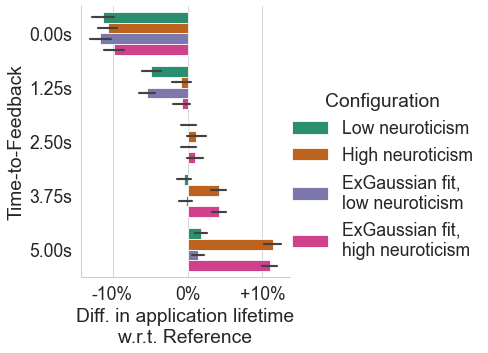

In [10]:
plot_data = duration_diff.set_index(["Configuration", "ttf"])[["CI95_Low", "CI95_High", "diff"]].stack().reset_index().rename(columns={0: "values"})
plot_data["ttf"] = plot_data["ttf"].apply(lambda e: f"{e:0.2f}s")

fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    y="ttf",
    x="values",
    hue="Configuration",
    aspect=1,
    # yerr=duration_diff["CI95%"].to_numpy(),
)
fg.set_axis_labels("Diff. in application lifetime\nw.r.t. Reference", "Time-to-Feedback")
for ax in fg.axes.flat:
    # ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    # ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}s"))
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%"))
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
plt.show()

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/893788334.py:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  ref_mean = durations.loc["Reference", "cumulative_duration"].mean()


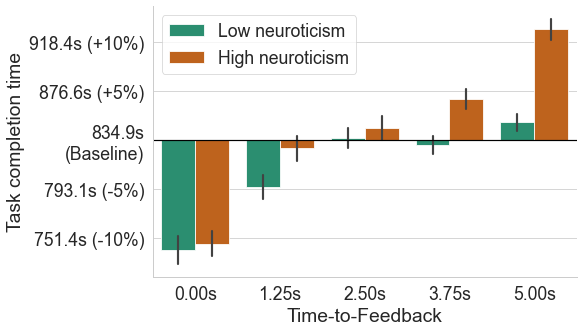

In [61]:
fg = sns.catplot(
    kind="bar",
    data=plot_data,
    estimator=lambda e: sorted(e)[1],
    errorbar=lambda e: (min(e), max(e)),
    x="ttf",
    y="values",
    hue="Configuration",
    hue_order=["Low neuroticism", "High neuroticism"],
    aspect=1.5,
    legend_out=False,
    # yerr=duration_diff["CI95%"].to_numpy(),
)
fg.set_axis_labels("Time-to-Feedback", "Task completion time")

ref_mean = durations.loc["Reference", "cumulative_duration"].mean()
def format_diff(x, p):
    raw_value = (1.0 + x) * ref_mean
    return f"{raw_value:0.01f}s ({x:+0.0%})" if not np.isclose(x, 0.0) else f"{raw_value:0.01f}s\n(Baseline)"

fg.refline(y=0, color="black", linestyle="-")
for ax in fg.axes.flat:
    # ax.yaxis.set_major_locator(tkr.MaxNLocator(integer=True))
    # ax.yaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:0.0f}s"))
    # ax.xaxis.set_major_formatter(tkr.FuncFormatter(
    #     lambda x, p: f"{x:+0.0%}" if x != 0.0 else "0%")
    # )
    ax.yaxis.set_major_formatter(tkr.FuncFormatter(format_diff))
    # ax.invert_yaxis()
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha="right", rotation_mode="anchor")
fg.add_legend(loc="upper left")
plt.show()

In [45]:
(
    durations.loc["Reference", "cumulative_duration"].mean(),
    durations.loc["Reference", "cumulative_duration"].sem()
)


/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/3203422193.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  durations.loc["Reference", "cumulative_duration"].mean(),
/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_86677/3203422193.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  durations.loc["Reference", "cumulative_duration"].sem()


(834.8671187979343, 8.37219897994505)